    Artificial Intelligence & Data Science
    Data Engineering - CM2606
    2024 April


    Gouri Napevithanage
    IIT ID- 20210808
    RGU ID-2237943

In [1]:
#install JDK
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version

#Install pyspark
  ! pip install pyspark==3.5.1
  ! pip install pmdarima
  ! pip install hvplot
  ! pip install panel
install_java()
! pyspark --version #Check the version

openjdk version "11.0.22" 2024-01-16
OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1)
OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.5.1
      /_/
                        
Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 1.8.0_402
Branch HEAD
Compiled by user heartsavior on 2024-02-15T11:24:58Z
Revision fd86f85e181fc2dc0f50a096855acf83a6cc5d9c
Url https://github.com/apache/spark
Type --help for more information.


In [2]:
import pyspark
import pyspark.sql
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from  pyspark.sql.functions import input_file_name
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, when, count, col, udf, lower, regexp_replace, unix_timestamp
from pyspark.sql.types import BooleanType, StructType, StructField, StringType, FloatType, DateType
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce
import panel as pn
pn.extension('tabulator')

import hvplot.pandas

In [3]:
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# create the spark session
conf = SparkConf().set("spark.ui.port", "4050") #Set the UI port to 4050 for the Spark session

#Create a SparkContext with the above configuration
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate() #To create dataframes and perform SQL operations

# Data Preprocessing.

Loading data & format inconsistencies

In [5]:
spark = SparkSession.builder.appName('HCHO data analysis').getOrCreate()# Initialize SparkSession with the application name

# Define the schema
schema = StructType([
    StructField("HCHO reading", FloatType(), True),
    StructField("Location", StringType(), True),
    StructField("Current Date", DateType(), True),
    StructField("Next Date", DateType(), True)]) #This format the data to a specific structure when reading data

#Loading Data
df1 = spark.read.csv('data/col_mat_nuw_output.csv', header=False, schema=schema) #add the first cv to a df without header row
df2 = spark.read.csv('data/kan_output.csv', header=False, schema=schema) #df of the 2nd csv
df3 = spark.read.csv('data/mon_kur_jaf_output.csv', header=False, schema=schema)

df = df1.union(df2).union(df3)# Join the dataframes into one by performing union operations
columns =["location"] #Define the string value column
df.show()
#Handling Inconsistencies

for column in columns:
    df = df.withColumn(column, lower(col(column))) #Convert all string values in the DataFrame to lower case

for column in columns:
    df = df.withColumn(column, regexp_replace(col(column), "\s", "_")) #Remove all white spaces from string values in the DataFrame


df.show()# Display the first 20 rows of the DataFrame

num_entries = df.count() # Count the number of rows in the DataFrame

print(f"Number of entries in the DataFrame: {num_entries}")


+-------------+--------------+------------+----------+
| HCHO reading|      Location|Current Date| Next Date|
+-------------+--------------+------------+----------+
| 1.9698344E-4|Colombo Proper|  2019-01-01|2019-01-02|
|  2.625522E-4|Colombo Proper|  2019-01-02|2019-01-03|
|  9.852119E-5|Colombo Proper|  2019-01-03|2019-01-04|
| 2.0993206E-4|Colombo Proper|  2019-01-04|2019-01-05|
| 1.7853372E-4|Colombo Proper|  2019-01-05|2019-01-06|
| 1.0822967E-4|Colombo Proper|  2019-01-06|2019-01-07|
| 3.9268294E-4|Colombo Proper|  2019-01-07|2019-01-08|
|  9.153156E-5|Colombo Proper|  2019-01-08|2019-01-09|
|  1.205979E-4|Colombo Proper|  2019-01-09|2019-01-10|
| 1.2977235E-4|Colombo Proper|  2019-01-10|2019-01-11|
| 2.2391882E-4|Colombo Proper|  2019-01-11|2019-01-12|
| 1.5694181E-4|Colombo Proper|  2019-01-12|2019-01-13|
|         NULL|Colombo Proper|  2019-01-13|2019-01-14|
| 1.3362919E-4|Colombo Proper|  2019-01-14|2019-01-15|
|  6.374418E-5|Colombo Proper|  2019-01-15|2019-01-16|
|1.1810622

Handling Missing values

In [6]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show() # Check for null values

+------------+--------+------------+---------+
|HCHO reading|location|Current Date|Next Date|
+------------+--------+------------+---------+
|        4864|       0|           0|        0|
+------------+--------+------------+---------+



In [7]:
num_rows_before = df.count()# number of rows before dropping null values

df = df.na.drop()# Drop rows with null values

num_rows_after = df.count()# number of rows after dropping null values

num_rows_dropped = num_rows_before - num_rows_after # number of rows dropped

print(f"Number of rows before dropping null values: {num_rows_before}")
print(f"Number of rows after dropping null values: {num_rows_after}")
print(f"Number of rows dropped: {num_rows_dropped}")

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show() #Check again for null values

Number of rows before dropping null values: 12782
Number of rows after dropping null values: 7918
Number of rows dropped: 4864
+------------+--------+------------+---------+
|HCHO reading|location|Current Date|Next Date|
+------------+--------+------------+---------+
|           0|       0|           0|        0|
+------------+--------+------------+---------+



Handling Data Duplication

In [8]:
# Check for duplicated rows across all columns
if df.count() > df.dropDuplicates().count():
    print("Data has duplicates")
else:
    print("No duplicates found")

No duplicates found


Handling outliers

In [9]:
column = "HCHO reading"# Select the column to remove the outliers

bounds = {
    c: dict(zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], 0))) #Create a dictionary to store quantile values
    for c in [column]}

iqr = bounds[column]['q3'] - bounds[column]['q1'] #Calculation of interquartile range (IQR)
lower_bound = bounds[column]['q1'] - (iqr * 1.5) #Calculation of upper bound for outliers
upper_bound = bounds[column]['q3'] + (iqr * 1.5) #calculation of lower bound

def is_outlier(value):# Define a function to check if a value is an outlier based on calculated bounds
    return (value < lower_bound) | (value > upper_bound)
is_outlier_udf = udf(is_outlier, BooleanType())

df = df.withColumn("outlier", is_outlier_udf(col(column)))# Returns True for outliers and False for non-outliers

outliers_count = df.filter(col("outlier") == True).count() # Count outliers before removing

print("Number of outliers before cleaning: ", outliers_count)

df0 = df.filter(col("outlier") == False)# Select the rows where 'outlier' column is false
outliers_count_after = df0.filter(col("outlier") == True).count()# Count outliers again

print("Number of outliers after cleaning: ", outliers_count_after)

Number of outliers before cleaning:  215
Number of outliers after cleaning:  0


In [10]:
# Group the df by 'location' and calculate mean, median, and standard deviation
df0_grouped = df0.groupBy("Location").agg(
    F.mean("HCHO reading").alias("mean"),
    F.expr('percentile_approx(`HCHO reading`, 0.5)').alias("median"),
    F.stddev("HCHO reading").alias("stddev")
)
df0_grouped.show()

+-------------------+--------------------+------------+--------------------+
|           Location|                mean|      median|              stddev|
+-------------------+--------------------+------------+--------------------+
|nuwara_eliya_proper|8.799096372229397E-5| 8.174215E-5|7.894000945972918E-5|
|     colombo_proper|1.485576533640281...|1.4571268E-4|8.388822521361778E-5|
|   deniyaya,_matara|8.818049407657948E-5| 8.092664E-5|7.584945309894013E-5|
|       kandy_proper|1.066285936246885...| 1.060346E-4|8.238293162656169E-5|
|      jaffna_proper|1.061667994349809...| 1.009731E-4|6.603454815760093E-5|
| bibile,_monaragala|1.249318856210353...|1.2424483E-4| 8.14183935102564E-5|
|  kurunegala_proper|1.306639412104597E-4|1.2470146E-4| 7.60784649941602E-5|
+-------------------+--------------------+------------+--------------------+



VIsualization

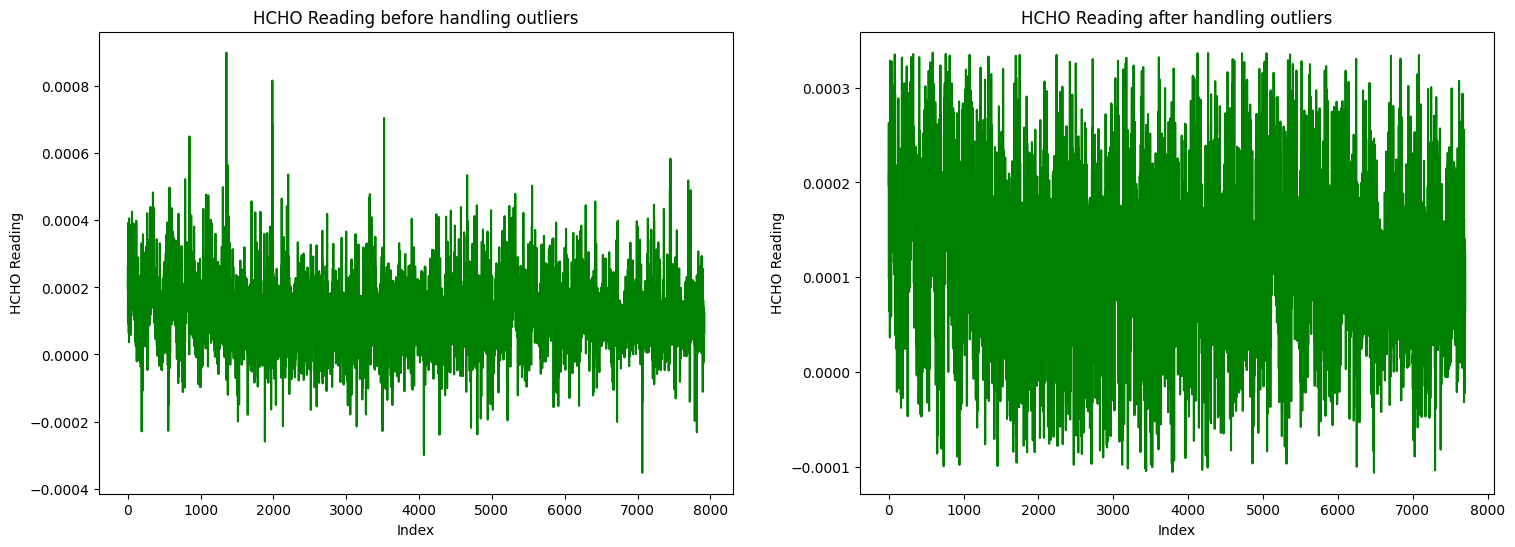

In [11]:
#HCHO Reading plots before and after handling outliers

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
#before outliers handling
df_pandas_test = df.toPandas()#Dataframe before
axs[0].plot(df_pandas_test['HCHO reading'], color='green')
axs[0].set_title('HCHO Reading before handling outliers')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('HCHO Reading')
#After outliers handling
df0_pandas = df0.toPandas()#Dataframe after
axs[1].plot(df0_pandas['HCHO reading'], color='green')
axs[1].set_title('HCHO Reading after handling outliers')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('HCHO Reading')

plt.show()

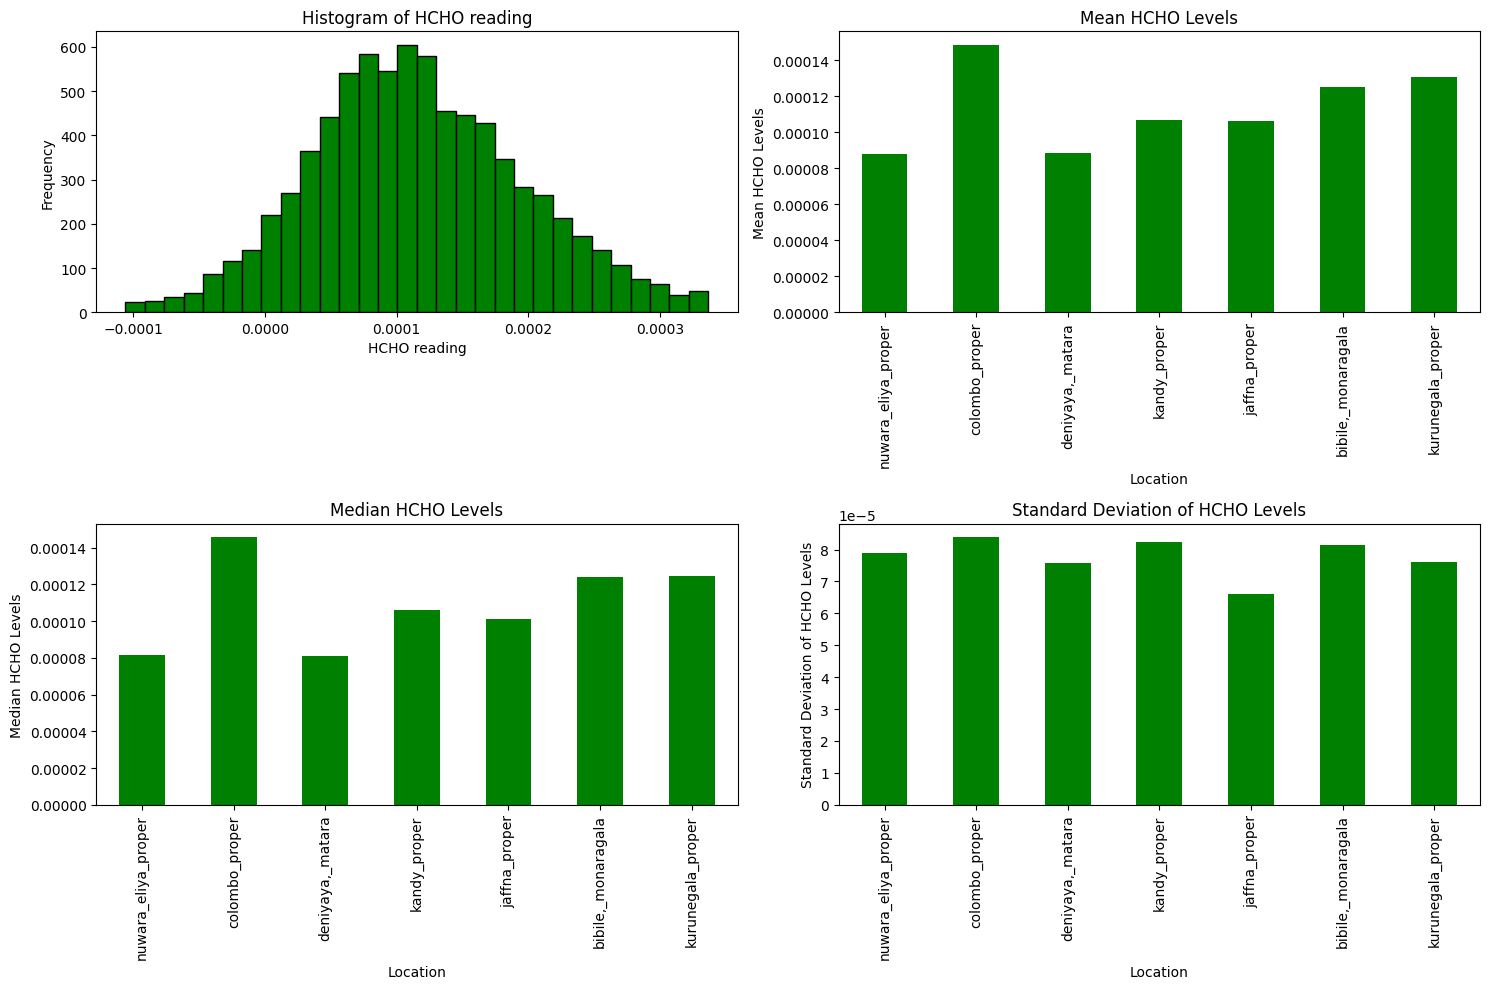

In [12]:
#Histogram visualization
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
df0_pandas = df0.select("HCHO reading").toPandas()#Main dataframe
#HCHO reading
axs[0, 0].hist(df0_pandas["HCHO reading"], bins=30, color='green', edgecolor='black')
axs[0, 0].set_title('Histogram of HCHO reading')
axs[0, 0].set_xlabel('HCHO reading')
axs[0, 0].set_ylabel('Frequency')
df0_pandas = df0_grouped.toPandas()#Grouped dataframe
df0_pandas.set_index("Location", inplace=True)# Set the index to 'Location'
#mean
df0_pandas['mean'].plot(kind='bar', ax=axs[0, 1], color='green')
axs[0, 1].set_title('Mean HCHO Levels')
axs[0, 1].set_xlabel('Location')
axs[0, 1].set_ylabel('Mean HCHO Levels')
#median
df0_pandas['median'].plot(kind='bar', ax=axs[1, 0], color='green')
axs[1, 0].set_title('Median HCHO Levels')
axs[1, 0].set_xlabel('Location')
axs[1, 0].set_ylabel('Median HCHO Levels')

#stddev
df0_pandas['stddev'].plot(kind='bar', ax=axs[1, 1], color='green')
axs[1, 1].set_title('Standard Deviation of HCHO Levels')
axs[1, 1].set_xlabel('Location')
axs[1, 1].set_ylabel('Standard Deviation of HCHO Levels')

plt.tight_layout()# Adjust the layout to prevent overlap
plt.show()

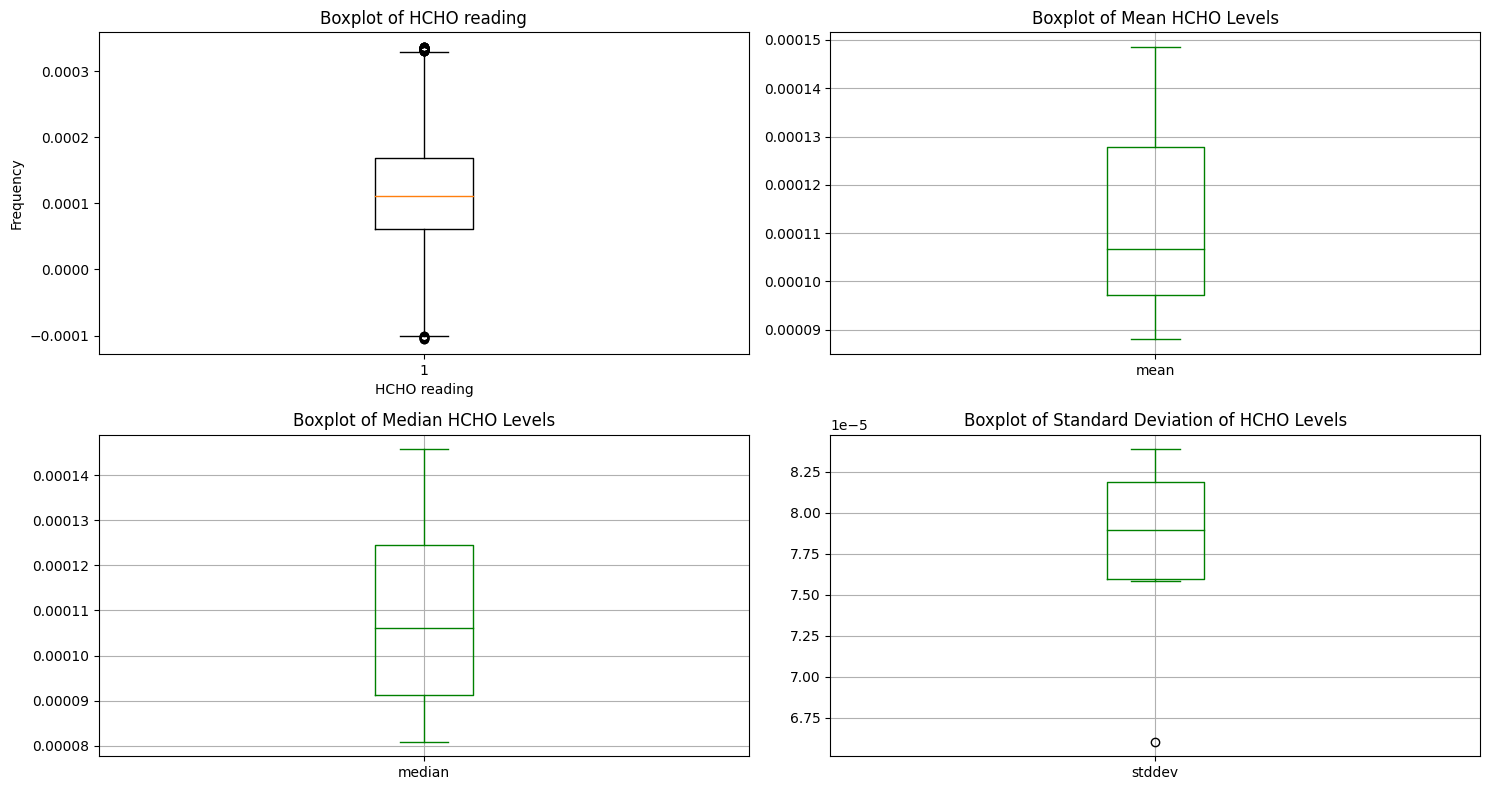

In [13]:
#Boxplot visualization
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
df0_pandas = df0.select("HCHO reading").toPandas()#Main dataframe
# HCHO reading
ax[0, 0].boxplot(df0_pandas["HCHO reading"])
ax[0, 0].set_title('Boxplot of HCHO reading')
ax[0, 0].set_xlabel('HCHO reading')
ax[0, 0].set_ylabel('Frequency')

df0_pandas = df0_grouped.toPandas() #Grouped dataframe
df0_pandas.set_index("Location", inplace=True)
# Mean
df0_pandas.boxplot(column='mean', color='green', ax=ax[0, 1])
ax[0, 1].set_title('Boxplot of Mean HCHO Levels')
# Median
df0_pandas.boxplot(column='median', color='green', ax=ax[1, 0])
ax[1, 0].set_title('Boxplot of Median HCHO Levels')
# Stddev
df0_pandas.boxplot(column='stddev', color='green', ax=ax[1, 1])
ax[1, 1].set_title('Boxplot of Standard Deviation of HCHO Levels')

plt.tight_layout()
plt.show()

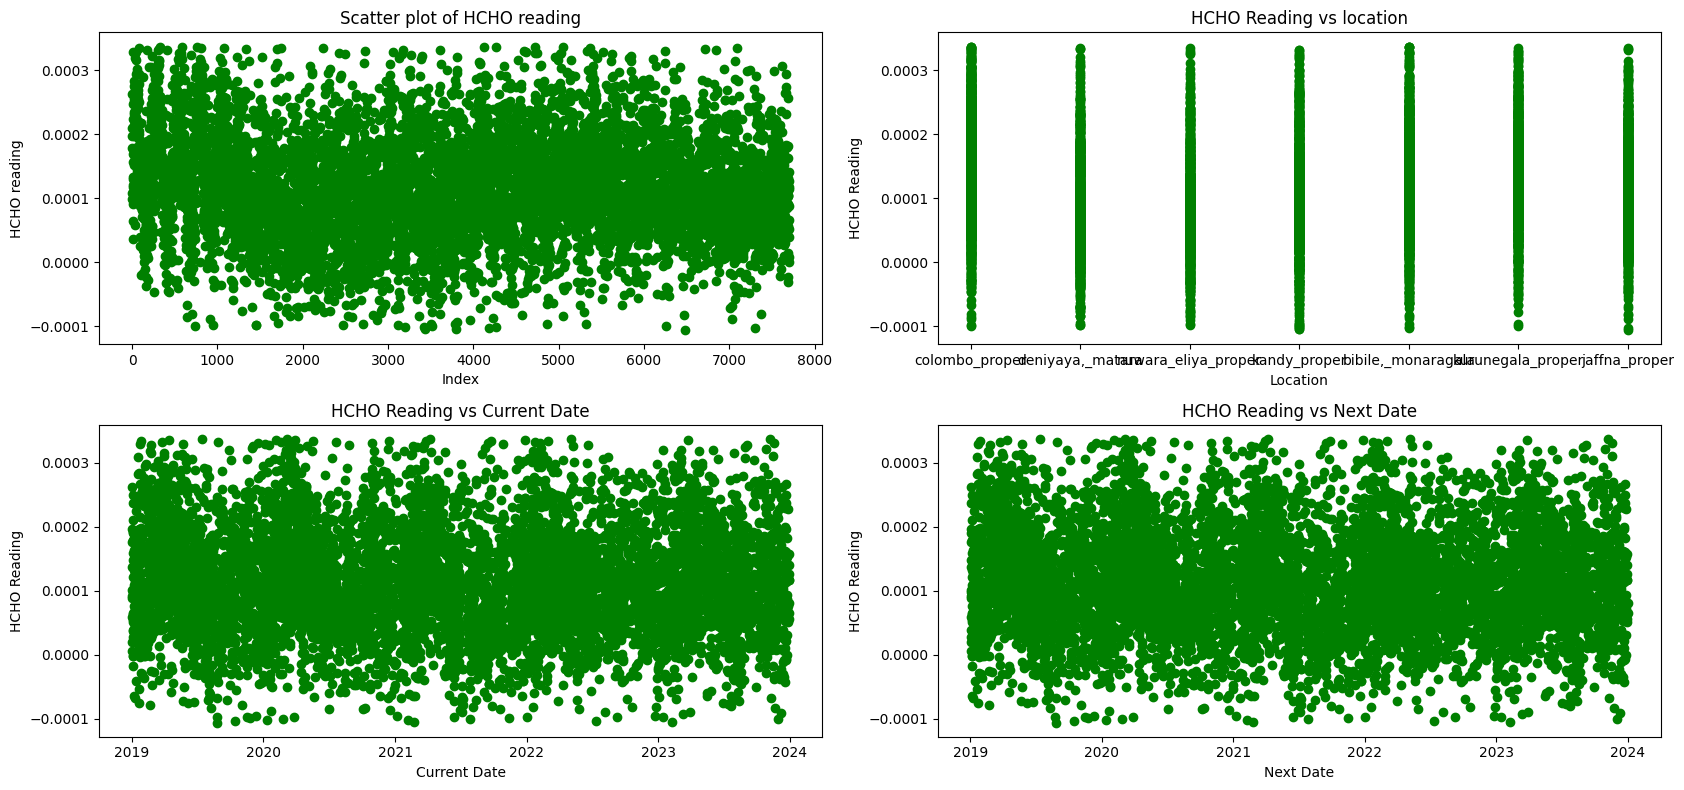

In [14]:
#scatter plot visualization
df0_pandas = df0.toPandas()
fig,ax =plt.subplots(nrows=2,ncols=2,figsize=(17,8))
# HCHO reading
ax[0, 0].scatter(range(len(df0_pandas["HCHO reading"])), df0_pandas["HCHO reading"], color='green')
ax[0, 0].set_title('Scatter plot of HCHO reading')
ax[0, 0].set_xlabel('Index')
ax[0, 0].set_ylabel('HCHO reading')
# HCHO Reading vs location
ax[0, 1].scatter(df0_pandas["location"], df0_pandas['HCHO reading'], color='green')
ax[0, 1].set_title('HCHO Reading vs location')
ax[0, 1].set_xlabel('Location')
ax[0, 1].set_ylabel('HCHO Reading')
# HCHO Reading vs Current Date
ax[1, 0].scatter(df0_pandas["Current Date"], df0_pandas['HCHO reading'], color='green')
ax[1, 0].set_title('HCHO Reading vs Current Date')
ax[1, 0].set_xlabel('Current Date')
ax[1, 0].set_ylabel('HCHO Reading')
# HCHO Reading vs Next Date
ax[1, 1].scatter(df0_pandas["Next Date"], df0_pandas['HCHO reading'], color='green')
ax[1, 1].set_title('HCHO Reading vs Next Date')
ax[1, 1].set_xlabel('Next Date')
ax[1, 1].set_ylabel('HCHO Reading')


plt.tight_layout()
plt.show()

# Spatio-Temporal Analysis

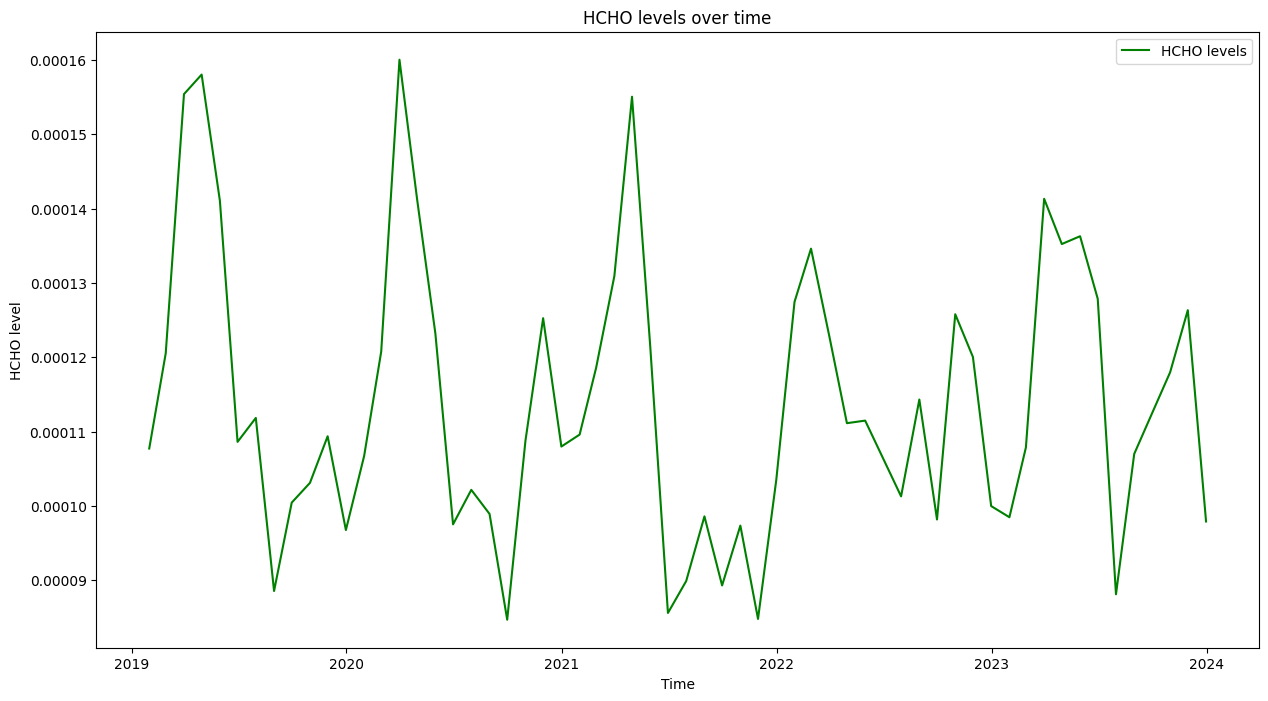

In [15]:
df = df0.toPandas()#Convert the spark dataframe to pandas dataframe
df['Current Date'] = pd.to_datetime(df['Current Date'])# Convert the date column to datetime
df.set_index('Current Date', inplace=True)# Set the date column as the index
monthly_df = df['HCHO reading'].resample('M').mean()# Resample the data to monthly frequency

plt.figure(figsize=(15,8))
plt.plot(monthly_df, label='HCHO levels',color='green')
plt.title('HCHO levels over time')
plt.xlabel('Time')
plt.ylabel('HCHO level')
plt.legend(loc='best')
plt.show()



In [16]:
# Define the locations
locations = ['colombo_proper', 'deniyaya,_matara', 'bibile,_monaragala', 'kurunegala_proper', 'jaffna_proper','nuwara_eliya_proper', 'kandy_proper']
high_altitude_locations = ['nuwara_eliya_proper', 'kandy_proper']
low_altitude_locations = ['colombo_proper', 'deniyaya,_matara', 'bibile,_monaragala', 'kurunegala_proper', 'jaffna_proper']

# Define dictionary where the keys are locations and the values are their classifications
location_classification = {location: 'High Altitude' for location in high_altitude_locations}
location_classification.update({location: 'Low Altitude' for location in low_altitude_locations})

# Define the classification function
def classify_location(location):
    return location_classification.get(location, 'Unknown')

# UDF from the classification function
classify_location_udf = udf(classify_location, StringType())

# new 'altitude' column to the DataFrame using the UDF
updated_df = df0.withColumn('altitude', classify_location_udf(df0['location']))

updated_df.show()

+-------------+--------------+------------+----------+-------+------------+
| HCHO reading|      location|Current Date| Next Date|outlier|    altitude|
+-------------+--------------+------------+----------+-------+------------+
| 1.9698344E-4|colombo_proper|  2019-01-01|2019-01-02|  false|Low Altitude|
|  2.625522E-4|colombo_proper|  2019-01-02|2019-01-03|  false|Low Altitude|
|  9.852119E-5|colombo_proper|  2019-01-03|2019-01-04|  false|Low Altitude|
| 2.0993206E-4|colombo_proper|  2019-01-04|2019-01-05|  false|Low Altitude|
| 1.7853372E-4|colombo_proper|  2019-01-05|2019-01-06|  false|Low Altitude|
| 1.0822967E-4|colombo_proper|  2019-01-06|2019-01-07|  false|Low Altitude|
|  9.153156E-5|colombo_proper|  2019-01-08|2019-01-09|  false|Low Altitude|
|  1.205979E-4|colombo_proper|  2019-01-09|2019-01-10|  false|Low Altitude|
| 1.2977235E-4|colombo_proper|  2019-01-10|2019-01-11|  false|Low Altitude|
| 2.2391882E-4|colombo_proper|  2019-01-11|2019-01-12|  false|Low Altitude|
| 1.5694181E

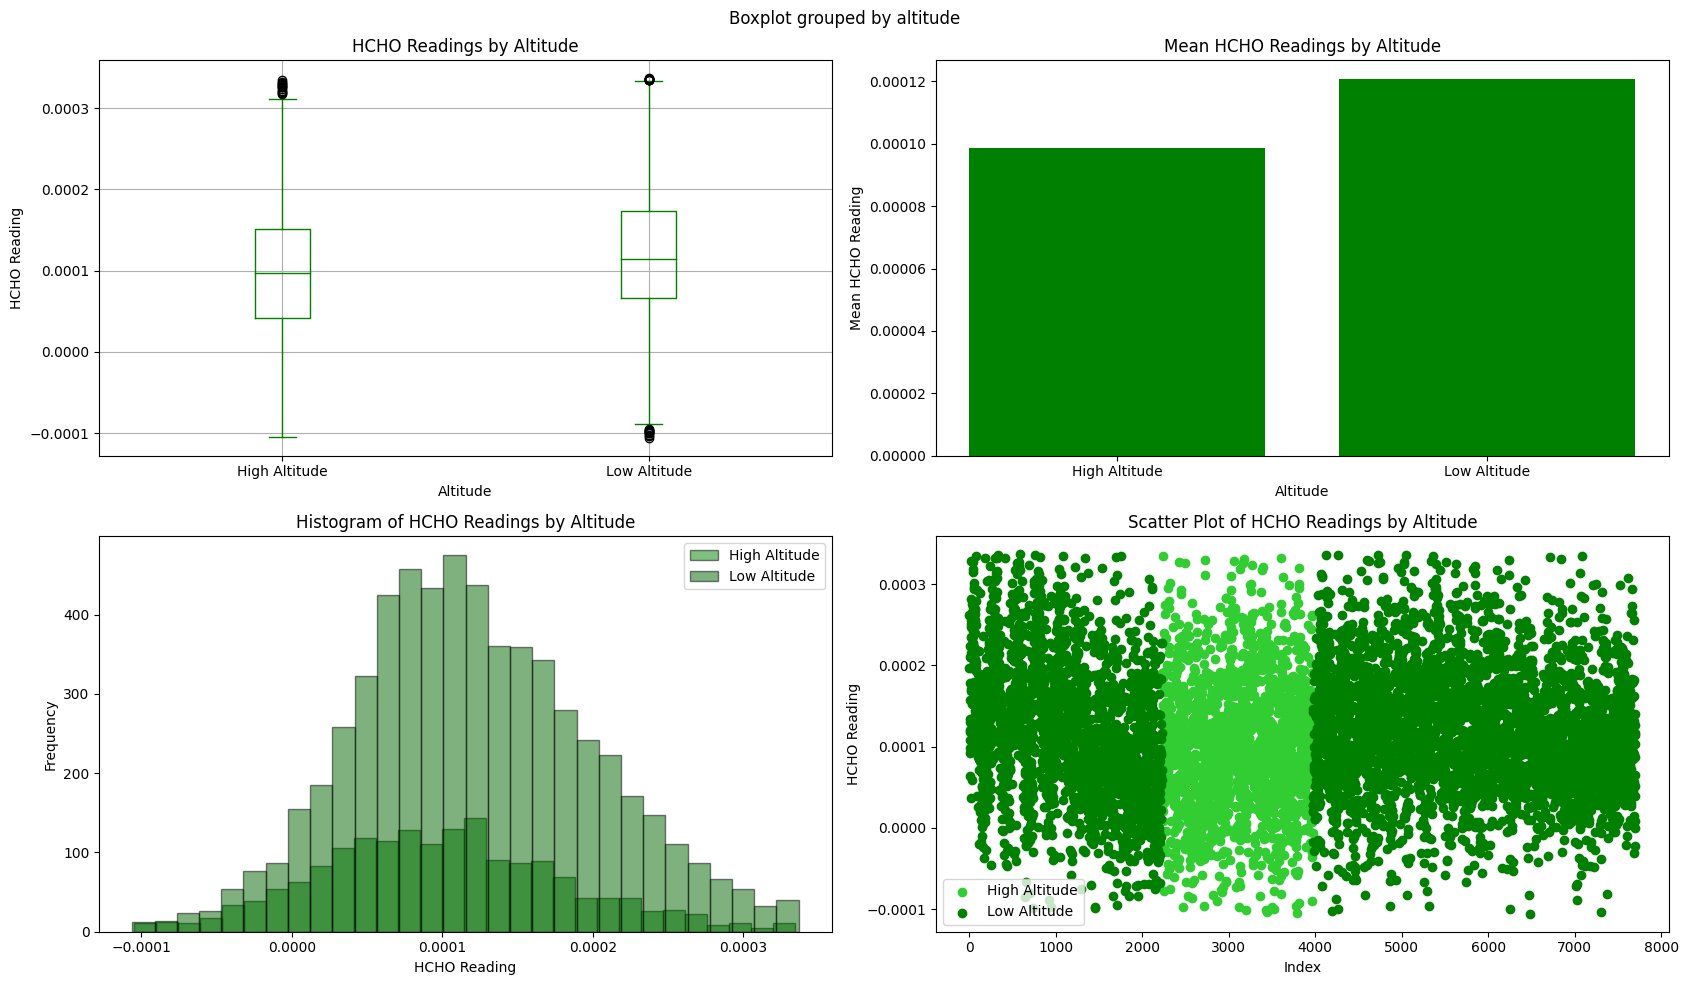

In [17]:
updated_df_pd = updated_df.toPandas()# Convert the updated DataFrame to pandas
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(17, 10))# Create a figure and a grid of subplots

# Boxplot of HCHO readings by altitude
updated_df_pd.boxplot(column='HCHO reading', by='altitude', ax=ax[0, 0],color='green')
ax[0, 0].set_title('HCHO Readings by Altitude')
ax[0, 0].set_xlabel('Altitude')
ax[0, 0].set_ylabel('HCHO Reading')
# Bar plot of the mean HCHO readings
grouped_df = updated_df_pd.groupby('altitude')['HCHO reading'].mean()
ax[0, 1].bar(grouped_df.index, grouped_df.values, color='green')
ax[0, 1].set_title('Mean HCHO Readings by Altitude')
ax[0, 1].set_xlabel('Altitude')
ax[0, 1].set_ylabel('Mean HCHO Reading')
# Histograms of HCHO readings for each altitude
high_altitude_df = updated_df_pd[updated_df_pd['altitude'] == 'High Altitude']
low_altitude_df = updated_df_pd[updated_df_pd['altitude'] == 'Low Altitude']
ax[1, 0].hist(high_altitude_df['HCHO reading'], bins=30, alpha=0.5, label='High Altitude',color='green', edgecolor='black')
ax[1, 0].hist(low_altitude_df['HCHO reading'], bins=30, alpha=0.5, label='Low Altitude', color='darkgreen',edgecolor='black')
ax[1, 0].set_title('Histogram of HCHO Readings by Altitude')
ax[1, 0].set_xlabel('HCHO Reading')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].legend(loc='best')
# Scatter plot of HCHO readings by altitude
for altitude, color in [('High Altitude', 'limegreen'), ('Low Altitude', 'green')]:
    altitude_df = updated_df_pd[updated_df_pd['altitude'] == altitude]
    ax[1, 1].scatter(altitude_df.index, altitude_df['HCHO reading'], color=color, label=altitude)
ax[1, 1].set_title('Scatter Plot of HCHO Readings by Altitude')
ax[1, 1].set_xlabel('Index')
ax[1, 1].set_ylabel('HCHO Reading')
ax[1, 1].legend(loc='best')

plt.tight_layout()
plt.show()


The correlation between altitude and HCHO reading is 0.11446344323544673


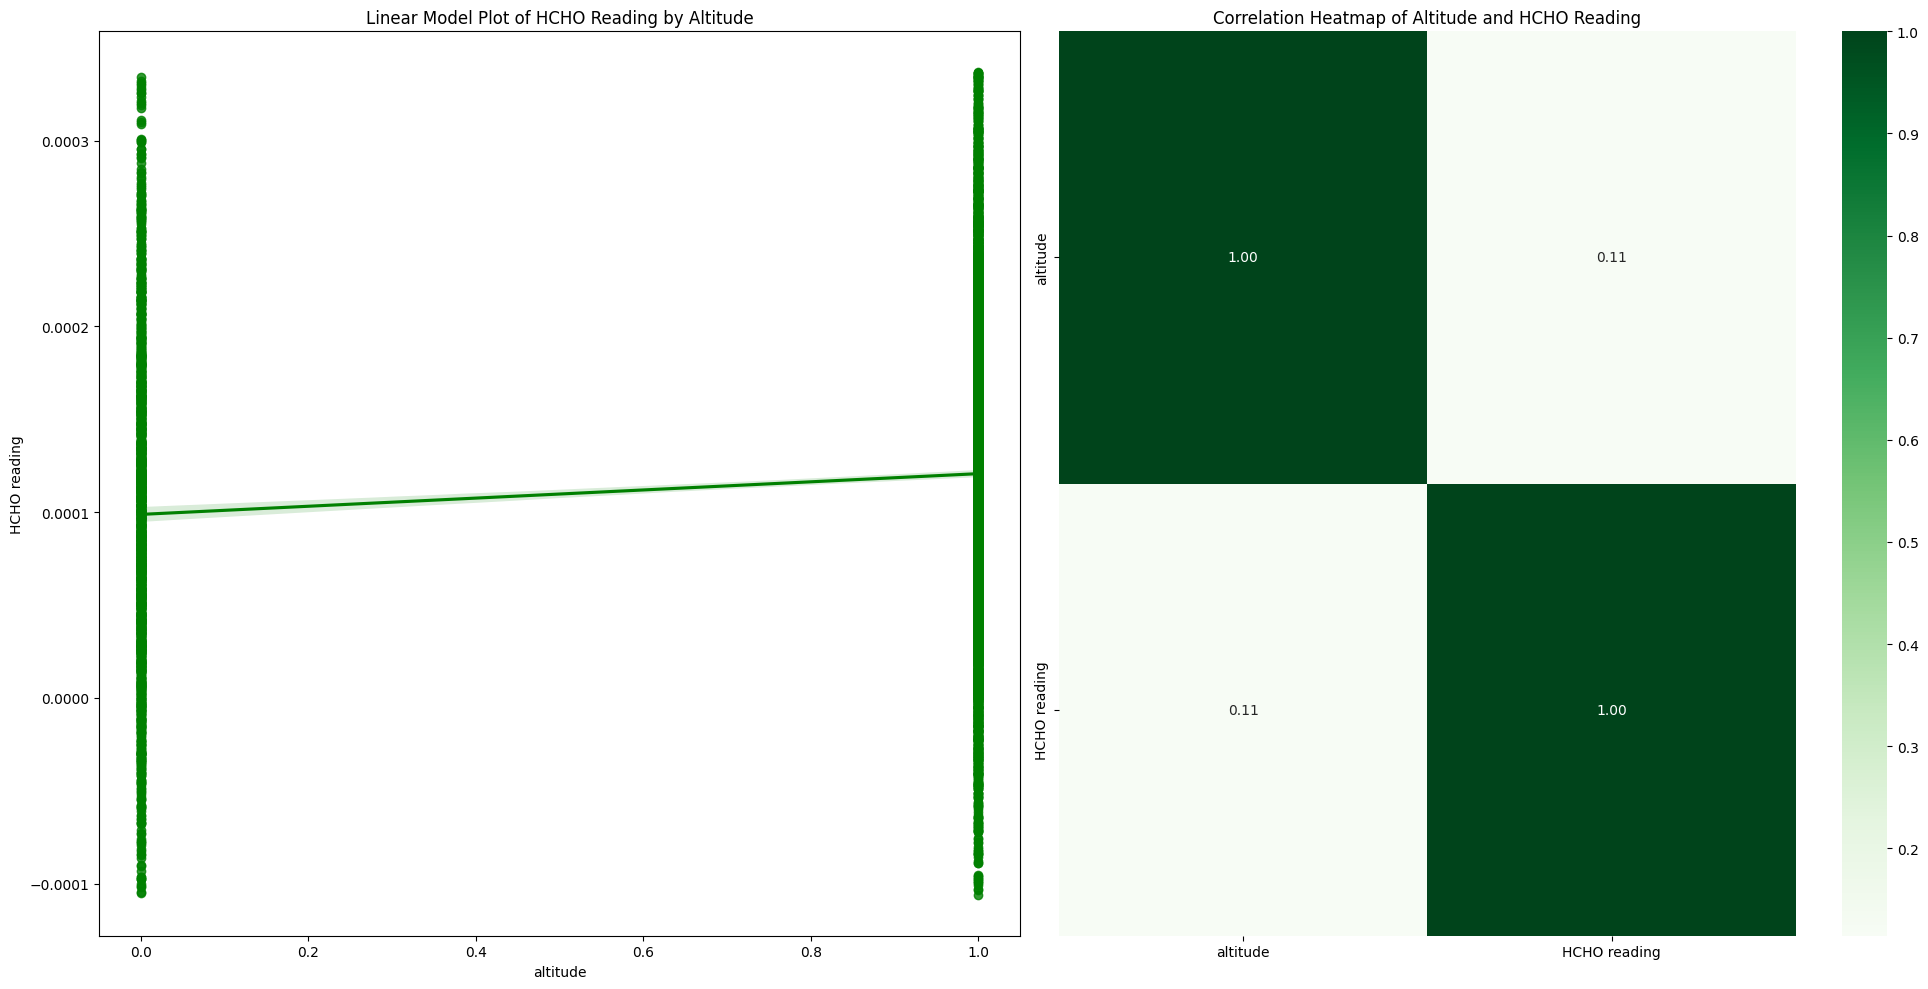

In [18]:
updated_df_pd = updated_df.toPandas()

updated_df_pd['altitude'] = updated_df_pd['altitude'].astype('category')# Convert the 'altitude' column to a categorical type
updated_df_pd['altitude'] = updated_df_pd['altitude'].cat.codes# Assign codes to the categories of the 'altitude' column
correlation = updated_df_pd['altitude'].corr(updated_df_pd['HCHO reading'])# Calculate the correlation between 'altitude' and 'HCHO reading'
print(f"The correlation between altitude and HCHO reading is {correlation}")
#plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
#Ragplot (lmplot doesn't support ax parameter directly)
sns.regplot(x='altitude', y='HCHO reading', data=updated_df_pd, color='green', ax=ax[0])
ax[0].set_title('Linear Model Plot of HCHO Reading by Altitude')
#Correlation matrix
corr_matrix = updated_df_pd[['altitude', 'HCHO reading']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Greens', fmt=".2f", ax=ax[1])
ax[1].set_title('Correlation Heatmap of Altitude and HCHO Reading')

plt.tight_layout()
plt.show()


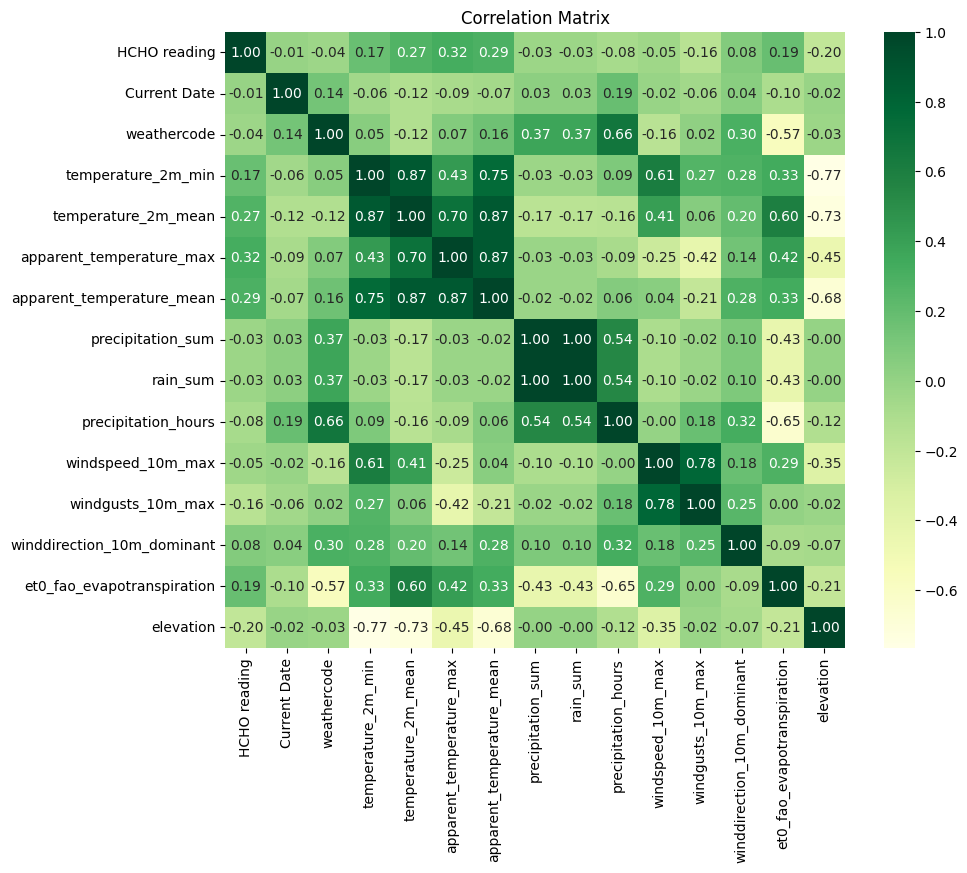

In [19]:
# Define the locations
locations = ['colombo_proper', 'deniyaya,_matara', 'bibile,_monaragala', 'kurunegala_proper', 'jaffna_proper','nuwara_eliya_proper', 'kandy_proper']
whether_locations=['Colombo', 'Kandy', 'Jaffna', 'Matara', 'Kurunegala']

# Read the weather data
whether_df = spark.read.csv('data/SriLanka_Weather_Dataset.csv', header=True, inferSchema=True)
whether_df = whether_df.drop('whethercode', 'sunrise', 'sunset', 'snowfall_sum', 'country', 'temperature_2m_max','apparent_temperature_min', 'shortwave_radiation_sum', 'precipitation_sum''et0_fao_evapotranspiration', 'latitude', 'longitude')

# Initialize an empty list to store the joined DataFrames
joined_dfs = []

for loc, wloc in zip(locations, whether_locations):
    # Filter the DataFrames based on the location
    df_loc = updated_df.filter(updated_df.location == loc)
    whether_df_loc = whether_df.filter(whether_df.city == wloc)

    # Join the DataFrames and drop missing values
    joined_df = df_loc.join(whether_df_loc, df_loc['Current Date'] == whether_df_loc.time, 'outer').dropna()

    # Add the joined DataFrame to the list
    joined_dfs.append(joined_df)

# Combine all the joined DataFrames
combined_df = reduce(lambda a, b: a.union(b), joined_dfs)
ml_df = combined_df.alias('ml_df')


# Convert 'Current Date' to Unix timestamp (number of seconds since 1970-01-01 00:00:00)
combined_df = combined_df.withColumn('Current Date', unix_timestamp('Current Date'))

# Drop the string column
dropped_df = combined_df.drop('location','Next Date','outlier','time','city','altitude')

# Convert the combined DataFrame to pandas and calculate the correlation matrix
correlation_matrix = dropped_df.toPandas().corr()

# Plot the correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='YlGn')
plt.title("Correlation Matrix")
plt.show()



# ML Model

In [20]:
# Define the columns to be dropped
columns_to_drop = ['Next Date','outlier','time','city','altitude']

# Drop the specified columns from the DataFrame
ml_df = ml_df.drop(*columns_to_drop)

# Convert the Spark DataFrame to a Pandas DataFrame for easier manipulation and visualization
ml_df = ml_df.toPandas()

# Display the resulting DataFrame
display(ml_df)

,HCHO reading,location,Current Date,weathercode,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_mean,precipitation_sum,rain_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,et0_fao_evapotranspiration,elevation
0,0.000197,colombo_proper,2019-01-01,2,23.1,26.1,33.2,28.7,0.0,0.0,0.0,14.4,29.9,14,4.58,16.0
1,0.000263,colombo_proper,2019-01-02,1,22.7,25.7,32.6,27.3,0.0,0.0,0.0,16.6,31.0,11,5.19,16.0
2,0.000099,colombo_proper,2019-01-03,0,22.6,26.1,33.4,27.8,0.0,0.0,0.0,16.0,31.0,10,5.21,16.0
3,0.000210,colombo_proper,2019-01-04,3,22.3,26.0,33.1,27.6,0.0,0.0,0.0,16.9,35.6,13,5.22,16.0
4,0.000179,colombo_proper,2019-01-05,3,22.6,26.4,34.6,28.9,0.0,0.0,0.0,16.8,32.4,8,5.01,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5360,0.000186,jaffna_proper,2023-06-12,63,24.5,26.2,33.9,30.1,9.3,9.3,12.0,16.8,43.6,209,3.69,124.0
5361,0.000217,jaffna_proper,2023-06-13,61,24.5,26.1,34.2,29.7,7.0,7.0,14.0,18.9,49.3,212,3.81,124.0
5362,0.000105,jaffna_proper,2023-06-14,53,24.7,26.7,33.8,30.2,2.0,2.0,8.0,19.9,43.6,208,4.09,124.0
5363,0.000214,jaffna_proper,2023-06-15,51,25.1,27.1,34.8,30.7,1.9,1.9,9.0,17.2,40.7,207,4.15,124.0


In [21]:
locations = ml_df['location'].unique() # Get the unique values in the 'location' column of the DataFrame
print(locations)

['colombo_proper' 'deniyaya,_matara' 'bibile,_monaragala'
 'kurunegala_proper' 'jaffna_proper']


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-10878.409, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-13228.216, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-13974.569, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-13497.310, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-14189.391, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-14276.491, Time=0.47 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-14323.760, Time=0.79 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-14371.864, Time=0.39 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-14370.428, Time=0.53 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-14322.750, Time=0.37 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-14531.765, Time=0.85 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-14532.739, Time=0.67 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-14534.285, Time=0.62 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-14536.035, Time=0.44 sec
 ARIM

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Model evaluation for colombo_proper
Model mean squared error: ;6.2417940344918345e-09
Model R-squared : ;0.1564041007459377


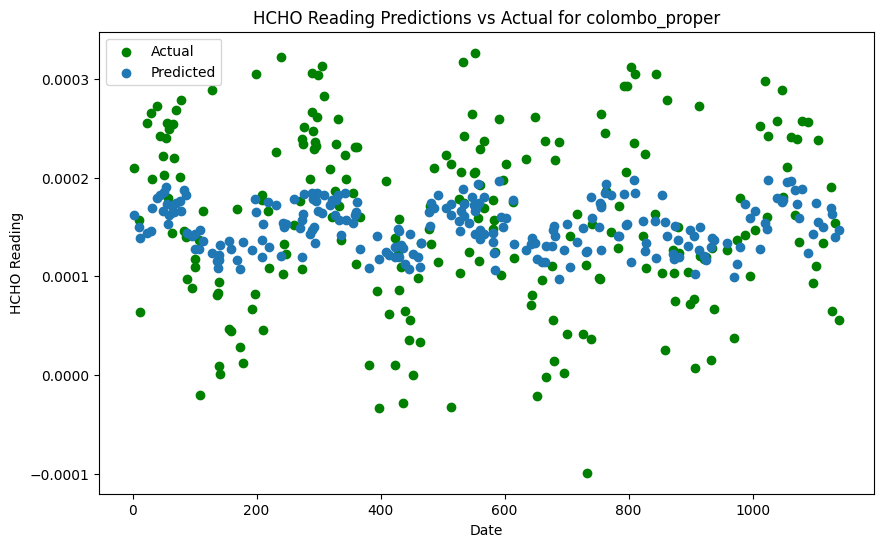

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-11046.630, Time=1.95 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-10530.781, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-10807.539, Time=0.63 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-10652.299, Time=0.42 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-11041.296, Time=0.66 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-11026.677, Time=1.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-10520.781, Time=1.95 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-11056.754, Time=1.98 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-7454.037, Time=1.81 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-10518.773, Time=3.20 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-10517.551, Time=0.50 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-10520.470, Time=0.44 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=-8365.094, Time=0.81 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-11144.570, Time=0.60 sec
 ARIMA(

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Model evaluation for deniyaya,_matara
Model mean squared error: ;5.620409333854044e-09
Model R-squared : ;-0.07004576634934523


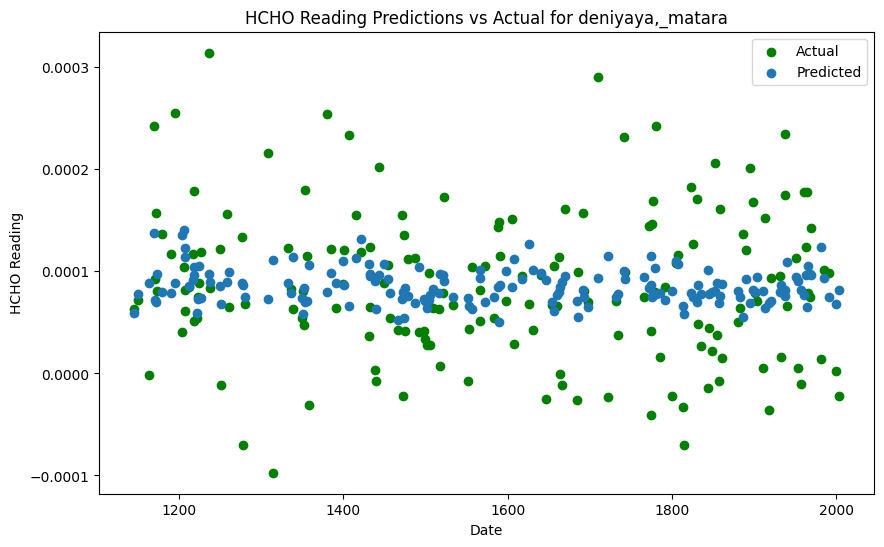

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-12671.594, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-11778.860, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-12331.801, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-12006.335, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-12663.919, Time=1.32 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-12611.671, Time=0.96 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-9953.036, Time=1.63 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-12431.129, Time=1.98 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-12621.598, Time=0.55 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-12325.814, Time=1.27 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-12548.096, Time=0.73 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-9811.256, Time=0.52 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-12748.525, Time=1.54 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-12749.001, Time=1.28 sec
 ARIMA(

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Model evaluation for bibile,_monaragala
Model mean squared error: ;6.567265398168919e-09
Model R-squared : ;0.07804863568519305


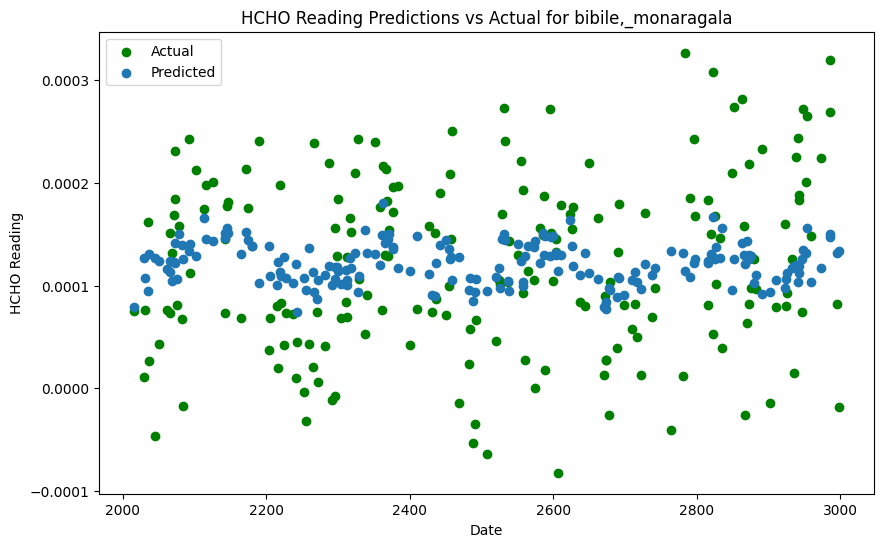

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-13750.611, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-12660.030, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-13361.209, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-12916.716, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-13753.644, Time=0.69 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-13007.512, Time=0.43 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-10509.032, Time=0.40 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-13244.349, Time=1.53 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-13077.331, Time=0.46 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-10730.324, Time=1.24 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-13764.972, Time=1.90 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-12648.030, Time=0.84 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-12648.030, Time=1.26 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-6900.240, Time=3.01 sec
 ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Model evaluation for kurunegala_proper
Model mean squared error: ;5.642261050049731e-09
Model R-squared : ;0.07938466197690464


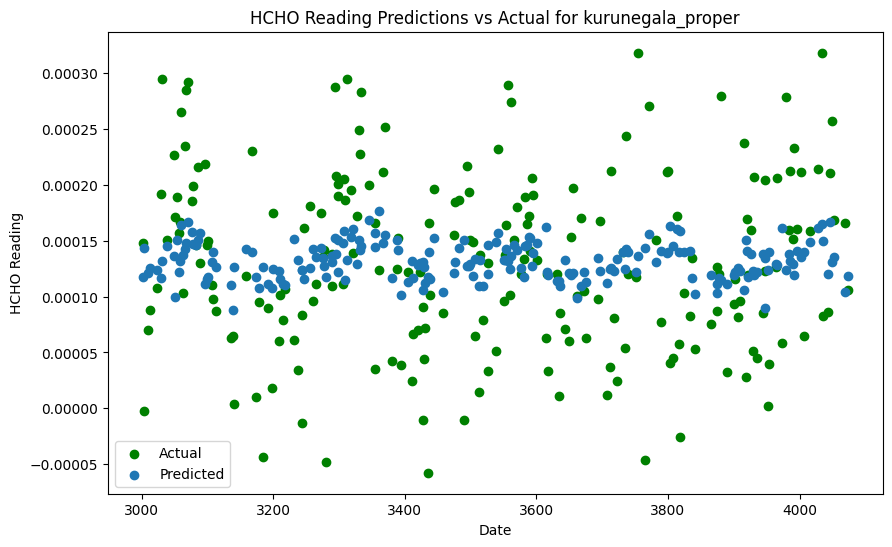

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-16803.818, Time=0.93 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-15614.679, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-16376.883, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-15917.744, Time=0.37 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-16782.826, Time=0.89 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-16750.941, Time=0.48 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-16801.850, Time=0.94 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-15604.629, Time=1.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-16749.808, Time=0.45 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-16790.515, Time=5.62 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-16674.252, Time=0.37 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-15602.665, Time=1.16 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-16915.338, Time=1.89 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-16918.146, Time=1.58 sec
 ARIM

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Model evaluation for jaffna_proper
Model mean squared error: ;4.028948170965015e-09
Model R-squared : ;0.025520217853137184


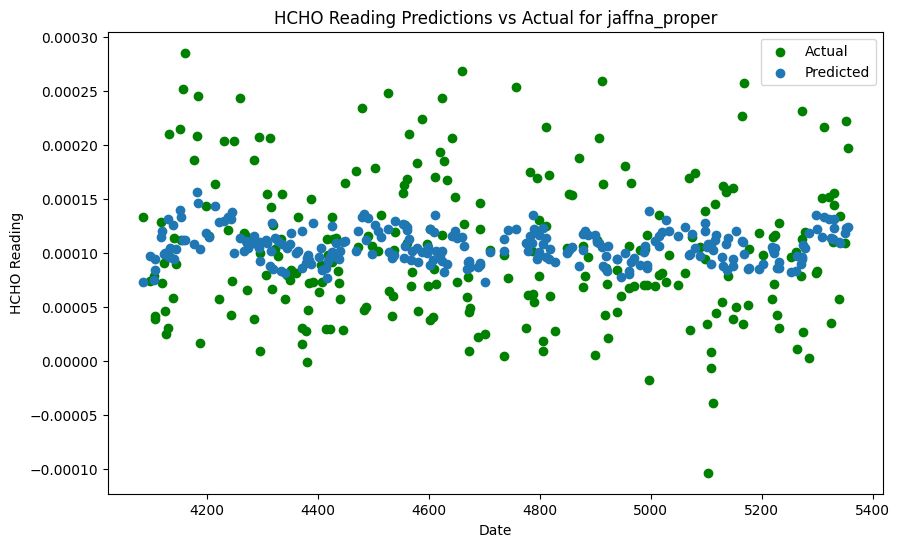

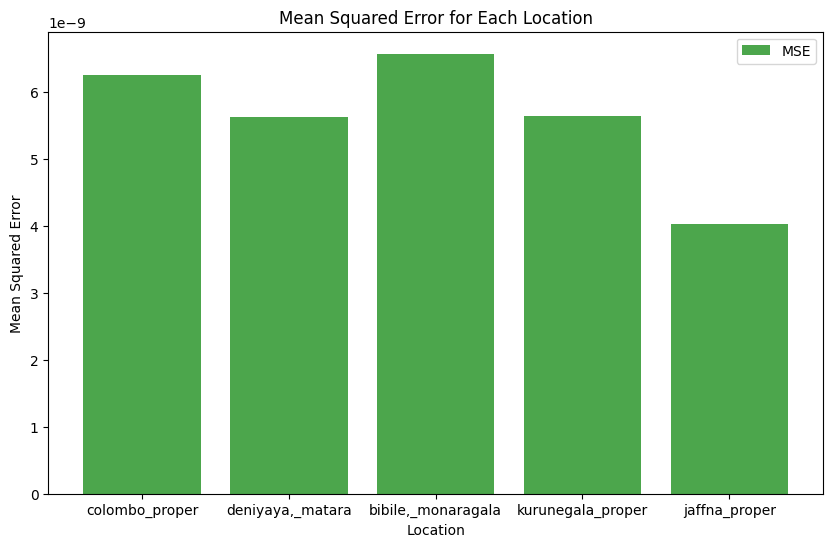

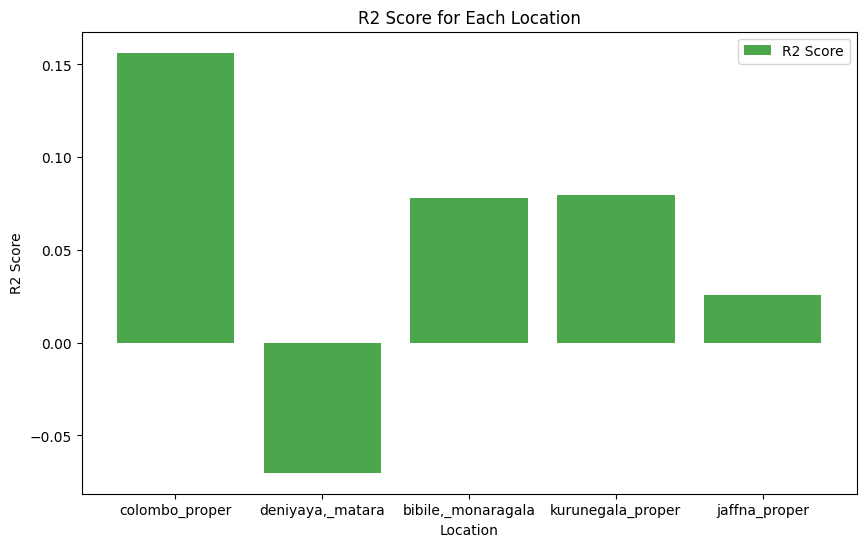

In [22]:
# Initialize empty lists to store Mean Squared Error (MSE) and R-squared (R2) scores for each location
mse_scores = []
r2_scores = []

# Loop over each location
for location in locations:
    # Filter the DataFrame for the current location
    df = ml_df[ml_df['location'] == location]
    # Define the independent variable (date) and dependent variable (HCHO reading)
    x = df['Current Date']
    y = df['HCHO reading']

    # Define the external features to be used in the model
    external_features = [
        'weathercode',
        'temperature_2m_mean',
        'apparent_temperature_mean',
        'precipitation_sum',
        'rain_sum',
        'precipitation_hours',
        'windspeed_10m_max',
        'elevation'
    ]

    # Extract the external features from the DataFrame
    x_ext = df [external_features]

    # Split the data into training and testing sets
    x_hist_train, x_hist_test, y_hist_train, y_hist_test = train_test_split(x, y, test_size=0.2, random_state=42)
    x_external_train, x_external_test, _, _ = train_test_split(x_ext, y, test_size=0.2, random_state=42)

    # Train an ARIMA model on the historical data
    arima_model = auto_arima(y_hist_train, seasonal=False, trace=True)
    arima_order = arima_model.order
    arima_model = ARIMA(y_hist_train, order=arima_order)
    arima_model_fit = arima_model.fit()

    # Train a Random Forest model on the external features
    scaler = StandardScaler()
    train_ext = scaler.fit_transform(x_external_train)
    test_ext = scaler.fit_transform(x_external_test)
    ext_model = RandomForestRegressor(n_estimators= 100, random_state=42)
    ext_model.fit(train_ext, y_hist_train)

    # Make predictions using both models
    hist_pred = arima_model_fit.forecast(steps=len(x_hist_test))
    ext_pred = ext_model.predict(test_ext)
    combined_pred = (hist_pred + ext_pred)/2

    # Calculate the MSE and R2 scores for the combined predictions
    mse = mean_squared_error(y_hist_test, combined_pred)
    r_sq = r2_score(y_hist_test, combined_pred)

    # Append the scores to the respective lists
    mse_scores.append(mse)
    r2_scores.append(r_sq)

    # Print the model evaluation metrics for the current location
    print(f"Model evaluation for {location}")
    print(f"Model mean squared error: ;{mse}")
    print(f"Model R-squared : ;{r_sq}")

    # Plot the actual vs predicted HCHO readings for the current location
    plt.figure(figsize=(10, 6))
    plt.scatter(y_hist_test.index, y_hist_test, label='Actual',color='green')
    plt.scatter(y_hist_test.index, combined_pred, label='Predicted')
    plt.title(f'HCHO Reading Predictions vs Actual for {location}')
    plt.xlabel('Date')
    plt.ylabel('HCHO Reading')
    plt.legend()
    plt.show()

# Plot the MSE for each location
plt.figure(figsize=(10, 6))
plt.bar(locations, mse_scores, alpha=0.7, label='MSE', color='green')
plt.title('Mean Squared Error for Each Location')
plt.xlabel('Location')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Plot the R2 score for each location
plt.figure(figsize=(10, 6))
plt.bar(locations, r2_scores, alpha=0.7, label='R2 Score', color='green')
plt.title('R2 Score for Each Location')
plt.xlabel('Location')
plt.ylabel('R2 Score')
plt.legend()
plt.show()

# Interactive dashboard

In [26]:
# Define the features you want to include in the dropdown
features = ['Current Date',
            'weathercode',
            'temperature_2m_mean',
            'apparent_temperature_mean',
            'precipitation_sum',
            'rain_sum', 'precipitation_hours',
            'windspeed_10m_max',
            'windgusts_10m_max',
            'winddirection_10m_dominant',
            'et0_fao_evapotranspiration',
            'elevation']
locations = ['Colombo Proper', 'Kandy Proper', 'Jaffna Proper', 'Kurunegala Proper']

# Create a dropdown widget
feature_select = pn.widgets.Select(name='Select Feature', options=features)

# Define a function to create the scatter plot based on the selected feature
@pn.depends(feature_select.param.value)
def create_scatter_plot(feature):
    return ml_df.hvplot.scatter(feature, 'HCHO reading', title=f'{feature} vs HCHO')


# Create a dropdown widget for locations
location_select = pn.widgets.Select(name='Select Location', options=locations)

# Define a function to create the scatter plot based on the selected location
@pn.depends(location_select.param.value, feature_select.param.value)
def create_location_scatter_plot(location, feature):
    df_location = ml_df[ml_df['location'] == location]
    return df_location.hvplot.scatter(feature, 'HCHO reading', title=f'{feature} vs HCHO for {location}')

# Update the Panel dashboard
dashboard = pn.Column(
    "# ** HCHO READINGS DASHBOARD ** ",
    "This dashboard shows how HCHO readings vary across different features.",
    feature_select,
    create_scatter_plot,
    "## PLOT DATA FOR EACH LOCATION",
    location_select,
    create_location_scatter_plot
)

# Show the dashboard
dashboard.show()

Launching server at http://localhost:43979
